# Code along with visualisation for Hair concerns

In [ ]:
!pip install datasets matplotlib transformers scikit-learn torch torchviz

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    BertModel,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
import torch
import torch.nn as nn
import numpy as np
from datasets import load_metric
import matplotlib.pyplot as plt
from torchviz import make_dot

# Load datasets
raw_train_ds = Dataset.from_json("./data.train.jsonlines")
raw_val_ds = Dataset.from_json("./data.validation.jsonlines")
raw_test_ds = Dataset.from_json("./data.test.jsonlines")

print(raw_train_ds)
print(raw_val_ds)
print(raw_test_ds)


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'text', 'uuid', 'ewg_rating', 'scalp_rating'],
    num_rows: 66
})
Dataset({
    features: ['id', 'text', 'uuid', 'ewg_rating', 'scalp_rating'],
    num_rows: 13
})
Dataset({
    features: ['id', 'text', 'uuid', 'ewg_rating', 'scalp_rating'],
    num_rows: 15
})


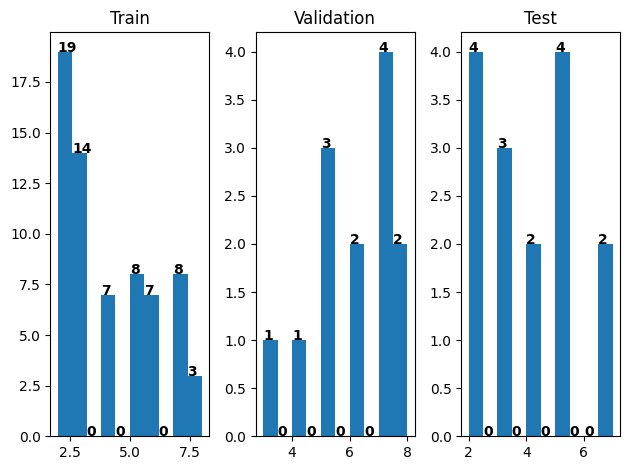

In [ ]:

# Plot distributions
fig, axs = plt.subplots(1, 3, tight_layout=True)
distributions = []

axs[0].set_title("Train")
axs[1].set_title("Validation")
axs[2].set_title("Test")
train_distributions = axs[0].hist(raw_train_ds["hair_concerns_rating"], bins=10)
val_distributions = axs[1].hist(raw_val_ds["hair_concerns_rating"], bins=10)
test_distributions = axs[2].hist(raw_test_ds["hair_concerns_rating"], bins=10)

for distributions, ax in zip([train_distributions, val_distributions, test_distributions], axs):
    for j in range(10):
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")


In [ ]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModel,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import AdamW
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.nn.functional as F

BASE_MODEL = "bert-base-uncased"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 20

# Load the pre-trained BERT model
bert_model = AutoModel.from_pretrained(BASE_MODEL)

# Add a fully connected layer on top of the BERT model
num_labels = 10
hidden_size = bert_model.config.hidden_size
dropout = 0.3

In [ ]:

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return loss, logits
        return logits


# Initialize the model
model = BertClassifier()

# Set the model to evaluation mode
model.eval()

# Example input
input_ids = torch.tensor([[31, 51, 99], [15, 5, 0]])
attention_mask = torch.tensor([[1, 1, 1], [1, 1, 0]])

# Get the model output
with torch.no_grad():
    output = model(input_ids, attention_mask)

# Print the output
print(output)

tensor([[ 6.3462e-02, -9.1033e-02, -2.9706e-02, -2.0683e-01,  2.6019e-01,
         -6.1956e-02, -2.4198e-02, -1.9889e-04,  6.7447e-02, -5.5872e-02],
        [ 1.1777e-01, -2.0429e-02,  1.7126e-01, -2.2325e-02, -1.3271e-02,
          6.2876e-02, -2.2673e-02,  1.5236e-01, -5.3527e-02,  2.6735e-01]])


In [ ]:

# Load the dataset
ds = load_dataset('json', data_files={'train': './data.train.jsonlines', 'validation': './data.validation.jsonlines', 'test': './data.test.jsonlines'})

# Preprocess the dataset
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

def preprocess_function(examples):
    label = examples["hair_concerns_rating"]
    examples = tokenizer(
        examples["text"], truncation=True, padding="max_length", max_length=256
    )
    examples["label"] = label
    return examples

ds = ds.map(preprocess_function, batched=True)

# Create a DataCollator to pad the input sequences
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

In [ ]:

# Create a TrainingArguments object to specify the training hyperparameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=25,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy="epoch",
    learning_rate=2e-5,
    save_total_limit=2,
    save_steps=500,
    load_best_model_at_end=True,
)

# Create a Trainer object to train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds['train'],
    eval_dataset=ds['validation'],
    data_collator=data_collator,
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1))},
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.228843,0.000000
2,2.024300,2.228889,0.000000
3,2.024300,2.228042,0.000000
4,2.023400,2.227142,0.000000
5,2.023400,2.227235,0.000000
6,2.017800,2.227295,0.000000
7,2.017800,2.226705,0.000000
8,2.032100,2.225986,0.000000
9,2.032100,2.226229,0.000000
10,1.975000,2.223162,0.000000


TrainOutput(global_step=125, training_loss=1.9662290725708007, metrics={'train_runtime': 414.4764, 'train_samples_per_second': 3.981, 'train_steps_per_second': 0.302, 'total_flos': 0.0, 'train_loss': 1.9662290725708007, 'epoch': 25.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 2.1883223056793213,
 'eval_accuracy': 0.07692307692307693,
 'eval_runtime': 0.2451,
 'eval_samples_per_second': 53.04,
 'eval_steps_per_second': 4.08,
 'epoch': 25.0}

In [ ]:

# Evaluate on test set
trainer.eval_dataset = ds["test"]
trainer.evaluate()


{'eval_loss': 2.101757049560547,
 'eval_accuracy': 0.26666666666666666,
 'eval_runtime': 0.2635,
 'eval_samples_per_second': 56.917,
 'eval_steps_per_second': 3.794,
 'epoch': 25.0}

In [ ]:

# Inference example
input_texts = ["CIR Supplement Manuscript\nInternational Journal of Toxicology\n2022, Vol. 41(Supplement 1) 80S –105S\n© The Author(s) 2022\nArticle reuse guidelines:sagepub.com/journals-permissions\nDOI: 10.1177/10915818221087202\njournals.sagepub.com/home/ijtSafety Assessment of Carbonate Salts as Used\nin Cosmetics\nWilbur Johnson*, Wilma F. Bergfeld†, Donald V. Belsito†, Ronald A. Hill‡,\nCurtis D. Klaassen†, Daniel C. Liebler†, James G. Marks‡, Ronald C. Shank†, Thomas J. Slaga†,\nPaul W. Snyder†, Lillian J. Gill§, and Bart Heldreth¶\nAbstract\nThe Expert Panel for Cosmetic Ingredient Safety (Panel) assessed the safety of 6 carbonate salts which function as absorbents,bulking agents, opacifying agents, pH adjusters, buffering agents, abrasives, and oral care agents in cosmetic products. The Panelreviewed relevant data relating to the safety of these ingredients, and concluded that these carbonate salts are safe in the present\npractices of use and concentration in cosmetics when formulated to be non-irritating.\nIntroduction\nThe safety of the following 6 carbonate salts as used in\ncosmetics is reviewed in this safety assessment:\nMagnesium Carbonate\nAmmonium Bicarbonate\nAmmonium Carbonate\nCalcium CarbonatePotassium BicarbonatePotassium Carbonate\nAccording to the International Cosmetic Ingredient Dic-\ntionary and Handbook (Dictionary ), the functions of these\ningredients in cosmetic products include: absorbents, bulking\nagents, opacifying agents, pH adjusters, buffering agents,\nabrasives, and oral care agents (Table 1).\n1Ingredient de ﬁni-\ntions are also included in Table 1.\nThe Expert Panel for Cosmetic Ingredient Safety (Panel)\nhas evaluated the safety of Sodium Sesquicarbonate, SodiumBicarbonate, and Sodium Carbonate in cosmetic products, andconcluded that these ingredients are “safe as presently used in\ncosmetics."]

encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=256, return_tensors="pt").to("cuda")
logits = model(**encoded)
predicted_class = torch.argmax(logits, axis=1)
print(predicted_class)


tensor([3], device='cuda:0')
